FOM_DATA_QWI_x = []
FOM_DATA_QWI_y = []
FOM_DATA_QWI_y_all = []
max_shift = 50
num_runs = 20
num_electric_fields = 1 # simulation cxx - not python
max_electric_field = 20
num_fields = 5

for k in range(num_fields):
    FOM_DATA_QWI_y = []
    for j in range(num_runs):
        wavelength_shift = max_shift/num_runs + j*max_shift/num_runs
        QWI_params = ["True", wavelength_shift]
        FOM_DATA_QWI_x.append(wavelength_shift)
        write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field/num_fields+k*max_electric_field/num_fields)

        # Run the C++ executable with material and layer files
        subprocess.run(['simulation.exe'])
        WL_range=[1200,1700]
        WL_of_interest=[1450,1700]
        FOM_DATA_QWI_y.append(show_results(num_electric_fields+1, WL_of_interest, WL_range))
    FOM_DATA_QWI_y_all.append(FOM_DATA_QWI_y)

In [22]:
import numpy as np
import scipy
import matplotlib.pyplot as plt 
from numpy.linalg import eig
import matplotlib.animation as animation
from IPython.display import clear_output
import subprocess
import random
from datetime import datetime

In [23]:
def getXY(BG_in):
    # Define the command to run the compiled C++ executable
    executable_path = r'C:\Users\jmcc0\Desktop\FYP\Frank code\getXY.exe'
    run_command = [executable_path]

    # Run the compiled C++ code
    process = subprocess.Popen(run_command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, cwd=r'C:\Users\jmcc0\Desktop\FYP\Frank code')

    # Provide input to the C++ program
    BG = BG_in
    process.stdin.write(str(BG).encode())
    process.stdin.close()

    # Read the output from the C++ program
    output = process.stdout.read().decode().strip()
    x_str, y_str = output.split('\t')
    x = float(x_str.split('=')[1])
    y = float(y_str.split('=')[1])
    # Now you have the x and y values from the C++ code
    print("x =", x)
    print("y =", y)
    
    return x, y

def getGap(layers):
    with open('input.txt', 'w') as f:
        f.write(str(int(len(layers))) + "\n")
        for layer in layers:
            f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")
    with open('materials.txt', 'w') as f:
        for material in materials:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        for material in alloys:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    
    executable_path = r'C:\Users\jmcc0\Desktop\FYP\QWI\getGap.exe'
    run_command = [executable_path]
    process = subprocess.Popen(run_command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, cwd=r'C:\Users\jmcc0\Desktop\FYP\QWI')
    
    output = process.stdout.read().decode().strip()
    lines = output.split('\n')

    # Initialize variables to store the values
    energy_e = None
    energy_lh = None
    energy_hh = None

    # Process each line
    for line in lines:
        parts = line.split(':')
        if len(parts) == 2:  # Ensure the line has a label and a value
            label = int(parts[0])
            value = float(parts[1])
            if label == 0:
                energy_e = value
            elif label == 1:
                energy_lh = value
            elif label == 2:
                energy_hh = value
    
    return max(1240/abs(energy_e-energy_lh), 1240/abs(energy_e-energy_hh))

# voigt function details
num_discrete = 2048
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = num_discrete/2
gamma = 50
sigma = gamma
PLOT_LIMIT=[]

def pad_func_zeros(func):
    func_new = np.zeros(2*len(func))
    j = 0
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    return func_new # twice in length

def pad_func_linear(func):
    func_new = np.zeros(2*len(func))
    j = 0
    del_f = np.abs(func[1]-func[2])
    for i in range(0, int(0.25*len(func_new))):
        func_new[i] = func[0]-0.5*(func[len(func)-1]-func[0]) + i*del_f
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    w=j-1
    j=1
    for i in range(int(0.75*len(func_new)), len(func_new)):
        func_new[i] = func[w] + j*del_f
        j+=1
    return func_new # twice in length

def pad_E(f):
    del_f = np.max(f)/(num_discrete-1)
    func_new = np.zeros(2*len(f))
    j = 0
    for i in range(len(func_new)):
        func_new[i] = del_f*i
    return func_new # twice in length

def convolve(f, g): # PAD ARRAYS BEFORE USE FRO ABSORPTION
    FFT_f = np.fft.fft(f)
    FFT_g = np.fft.fft(g)
    FG = FFT_f * FFT_g
    result = np.fft.ifft(FG)
    return np.real(result)

# plotting
PLOT_LIMIT = []#400,800]
Y_LIMIT = [] # leave blank for auto
ERROR_BARS = False
PLOT_FITTED = False
split_ = ","
LABEL_FONT_SIZE = 13
TICK_FONT_SIZE = 11
LINE_WIDTH = 0.5
MARKER_SIZE = 1
LEGEND = True
label_x = ""
label_y = ""
plot_title = ""
aspect_ratio = [9,9]

colours = [ 'black', 'dimgrey', 'lightslategrey', 'lightsteelblue', 'silver', 'cadetblue', 'darkcyan', 'darkslategray', 'seagreen', 'mediumseagreen', 'darkolivegreen', 'olivedrab', 'olive', 'yellowgreen', 'green', 'springgreen', 'mediumspringgreen', 'turquoise', 'lightseagreen']

def plot_graph(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (aspect_ratio[0],aspect_ratio[1])
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize = TICK_FONT_SIZE)
    plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    plt.plot(x, y, linewidth = LINE_WIDTH, color = 'dimgrey', marker = 's', markersize = MARKER_SIZE, markerfacecolor='dimgrey')
    plt.grid(True, alpha=0.2)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def plot_graphs(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #plt.xticks(fontsize = TICK_FONT_SIZE)
    #plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    i=0
    for ys in y:
        if i < len(colours):
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE, color = colours[i])
        else:
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE)
        i+=1
    plt.grid(True, alpha=0.2)
    if(LEGEND==True):
        plt.legend(legend)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()
    
def plot_graphs_distinct(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #plt.xticks(fontsize = TICK_FONT_SIZE)
    #plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    i=0
    for ys in y:
        if i < len(colours):
            plt.plot(x[i], ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE, color = colours[i])
        else:
            plt.plot(x[i], ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE)
        i+=1
    plt.grid(True, alpha=0.2)
    if(LEGEND==True):
        plt.legend(legend)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def make_array(y, number_steps):
    p = np.zeros(number_steps)
    for nr in range(0, number_steps):
        p[nr] = y
    return p

def read_in(file_path):
    x_data_ = []
    y_data_ = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split the line into x and y values
                x_val, y_val = map(float, line.strip().split())
                x_data_.append(x_val)
                y_data_.append(y_val)
    except FileNotFoundError:
        print("File not found:", file_path)

    # Convert lists to numpy arrays
    x_array_ = np.array(x_data_)
    y_array_ = np.array(y_data_)
    
    #plot_graph(x_array_, y_array_)
    
    return x_array_, y_array_

In [24]:
def parse_input_file(input_file):
    layers = []
    with open(input_file, 'r') as f:
        num_layers = int(f.readline().strip())
        for _ in range(num_layers):
            layer_info = f.readline().strip().split()
            material = layer_info[0]
            thickness = float(layer_info[1])
            layers.append((material, thickness))
    return layers

def parse_materials_file(materials_file):
    materials = {}
    with open(materials_file, 'r') as f:
        for line in f:
            material_info = line.strip().split()
            material = material_info[0]
            properties = [float(prop) for prop in material_info[1:]]
            materials[material] = properties
    return materials

def parse_simulation_parameters_file(simulation_params_file):
    with open(simulation_params_file, 'r') as f:
        qwi_target_shift = float(f.readline().split(" ")[1])
        num_electric_fields = int(f.readline().strip())
        max_applied_efield = float(f.readline().strip())
    return qwi_target_shift, num_electric_fields, max_applied_efield

In [25]:
def write_simulation_parameters(inter_mixing_params, num_electric_fields, max_electric_field):
    with open('simulation_parameters.txt', 'w') as f:
        f.write(f"{inter_mixing_params[0]} {inter_mixing_params[1]}\n")
        f.write(f"{num_electric_fields}\n")
        f.write(f"{max_electric_field}\n")

class Layer:
    def __init__(self, material, thickness): # thickness in [A]
        self.material = material
        self.thickness = thickness

class Material:
    def __init__(self, name, affinity, band_gap, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive):
        self.affinity = affinity
        self.band_gap = band_gap
        self.e_eff_mass = e_eff_mass
        self.lh_eff_mass = lh_eff_mass
        self.hh_eff_mass = hh_eff_mass
        self.name = name
        self.refractive = refractive
        
    def getEffectiveMass(self, p):
        if p == 0:
            return self.e_eff_mass
        if p == 1:
            return self.lh_eff_mass
        if p == 2:
            return self.hh_eff_mass
        
    def getBandgap(self):
        return self.band_gap
    
    def getRefractive(self):
        return self.refractive
    
# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.067, 0.08, 0.50, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.12, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.025, 0.40, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []

def BG_InGaAlAs(x, y):
    return 0.36 + 2.093*y + 0.629*x + 0.577*y*y + 0.436*x*x + 1.013*x*y - 2.0*x*y*(1-x-y); # [eV]
def EF_InGaAlAs(x, y): # Effective electron finity for placing conduction bands InGaAlAs
    return 0.5766 - 0.3439*BG_InGaAlAs(x, y) # [eV] 
def effMass_InGaAlAs(x, y, particle):
    return InAs.getEffectiveMass(particle)*(1-x-y) + GaAs.getEffectiveMass(particle)*(x) + AlAs.getEffectiveMass(particle)*(y);
def refractive_InGaAlAs(x, y):
    E_g = BG_InGaAlAs(x,y);
    x=(E_g-0.75)/0.72;
    w = 1240/E_g
    if (x>1.0): x = 1
    A = 9.689 - 1.012*x;
    B = 1.590 - 0.376*x;
    C = 1102.4 - 702.0*x + 330.4*x*x;
    if (C+100 < w):
        X = w*w-C*C
    else: 
        X = (200*w+10000)
    return np.sqrt(A + B*w*w/X);
def InGaAlAs_material(bandgap): # in nm
    bandgap = 1240/bandgap
    x, y = getXY(bandgap)
    temp = Material("In{}Ga{}Al{}As".format(1-x-y,x,y), EF_InGaAlAs(x, y), BG_InGaAlAs(x, y), effMass_InGaAlAs(x, y, 0), effMass_InGaAlAs(x, y, 1), effMass_InGaAlAs(x, y, 2), refractive_InGaAlAs(x,y))
    print(BG_InGaAlAs(x, y))
    alloys.append(temp)
    return temp

def findAlloys(layers, target):
    sigma = 2500
    sigma0 = 500
    sigma_prev = sigma0
    i = 0
    while i < 20:
        for layer in layers:
            if layer.material.name != 'InP':  # Exclude InP layers from modification
                old_bandgap = 1240/layer.material.band_gap
                new_bandgap = old_bandgap + (target - getGap(layers))  # Adjust each layer's bandgap individually
                layer.material = InGaAlAs_material(new_bandgap)
        with open('input.txt', 'w') as f:
            f.write(str(int(len(layers))) + "\n")
            for layer in layers:
                f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

        with open('materials.txt', 'w') as f:
            for material in materials:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
            for material in alloys:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

        testGap = getGap(layers)
        temp = sigma
        print(testGap)
        if testGap > target + 1:
            sigma = (sigma0 + sigma) / 2.0
            sigma_prev = temp
        elif testGap < target - 1:
            sigma0 = sigma
            sigma = (sigma_prev + sigma) / 2.0
        else:
            break
        i += 1
        
    if(i>=20): success = False
    else: success = True
    print("out: " + str(testGap))
    return layers, success

print(effMass_InGaAlAs(0.1831, 0.283, 2))

0.52868


In [29]:
layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1550), 60)
layer3 = Layer(InGaAlAs_material(1549.81), 100)
layer5 = Layer(InGaAlAs_material(1700), 67)
layer6 = Layer(InGaAlAs_material(1000), 30)
layer4 = Layer(InGaAlAs_material(1350), 45)
InP_layer2 = Layer(InGaAlAs_material(1240), 100)
layer3 = Layer(InGaAlAs_material(1400.81), 30)
InP_layer = Layer(InGaAlAs_material(1229.85), 150)
layer10 = Layer(InGaAlAs_material(1350), 30)
# layers = [InP_layer2, layer3,  InP_layer2]


layers = [InP_layer2, layer2,  InP_layer2]

print("Initial Bandgap: " + str(getGap(layers)))

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

num_electric_fields = 6 # simulation cxx - not python
max_electric_field = 11
wavelength_shift = 40 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
#subprocess.run(['simulation_multithread.exe'])

## DESIGN 1 GRADED

x = 0.423147
y = 0.0456408
0.8000003493770904
x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.468033
y = -1.11468e-15
0.7499006886428017
x = 0.127191
y = 0.346573
1.239998987280111
x = 0.329646
y = 0.140714
0.9185184364308158
x = 0.272712
y = 0.198606
1.0000008584908202
x = 0.354463
y = 0.115479
0.8852014907140199
x = 0.267205
y = 0.204205
1.0082528138747606
x = 0.329646
y = 0.140714
0.9185184364308158
Initial Bandgap: 1428.5105358412143


In [28]:
# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.067, 0.08, 0.50, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.12, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.025, 0.40, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []

layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1549.81), 30)
layer3 = Layer(InGaAlAs_material(1549.81), 100)
layer5 = Layer(InGaAlAs_material(1700), 75)
layer6 = Layer(InGaAlAs_material(1200), 30)
layer4 = Layer(InGaAlAs_material(1350), 40)
InP_layer2 = Layer(InGaAlAs_material(1150), 100)
layer3 = Layer(InGaAlAs_material(1400.81), 30)
InP_layer = Layer(InGaAlAs_material(1239.85), 100)

layers = [InP_layer2, layer3,  InP_layer2]

# GOOD DESIGN 
layers = [InP_layer2, layer2, layer6, layer5, layer4, InP_layer2]

print("Initial Bandgap: " + str(getGap(layers)))

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

num_electric_fields = 10 # simulation cxx - not python
max_electric_field = 10
wavelength_shift = 0 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
#subprocess.run(['simulation_multithread.exe'])

x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.468033
y = -1.11468e-15
0.7499006886428017
x = 0.250731
y = 0.220956
1.0333334315677287
x = 0.329646
y = 0.140714
0.9185184364308158
x = 0.222133
y = 0.250035
1.0782614863153481
x = 0.354463
y = 0.115479
0.8852014907140199
x = 0.27263
y = 0.198688
1.0001199377038916
Initial Bandgap: 1537.7460858781583


In [16]:
# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.067, 0.08, 0.50, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.12, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.025, 0.40, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []

layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1549.81), 30)
layer3 = Layer(InGaAlAs_material(1549.81), 100)
layer5 = Layer(InGaAlAs_material(1700), 85)
layer6 = Layer(InGaAlAs_material(1000), 30)
layer4 = Layer(InGaAlAs_material(1350), 40)
InP_layer2 = Layer(InGaAlAs_material(1150), 100)
layer3 = Layer(InGaAlAs_material(1400.81), 30)
InP_layer = Layer(InGaAlAs_material(1239.85), 100)

layers = [InP_layer2, layer3,  InP_layer2]

# asnpther good one at 1550 intermixed
layers = [InP_layer2, layer2, layer6, layer5, layer4, InP_layer2]

print("Initial Bandgap: " + str(getGap(layers)))

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

num_electric_fields = 10 # simulation cxx - not python
max_electric_field = 10
wavelength_shift = 0 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
#subprocess.run(['simulation_multithread.exe'])

x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.468033
y = -1.11468e-15
0.7499006886428017
x = 0.127191
y = 0.346573
1.239998987280111
x = 0.329646
y = 0.140714
0.9185184364308158
x = 0.222133
y = 0.250035
1.0782614863153481
x = 0.354463
y = 0.115479
0.8852014907140199
x = 0.27263
y = 0.198688
1.0001199377038916
Initial Bandgap: 1545.009618930853


In [19]:
# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.067, 0.08, 0.50, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.12, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.025, 0.40, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []

layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1549.81), 30)
layer3 = Layer(InGaAlAs_material(1549.81), 100)
layer5 = Layer(InGaAlAs_material(1700), 80)
layer6 = Layer(InGaAlAs_material(1000), 30)
layer4 = Layer(InGaAlAs_material(1350), 45)
InP_layer2 = Layer(InGaAlAs_material(1250), 100)
layer3 = Layer(InGaAlAs_material(1400.81), 30)
InP_layer = Layer(InGaAlAs_material(1229.85), 150)
layer10 = Layer(InGaAlAs_material(1350), 30)
layers = [InP_layer2, layer3,  InP_layer2]

# good design
layers = [InP_layer2, layer5, layer2, layer10, layer6, InP_layer2]

print("Initial Bandgap: " + str(getGap(layers)))

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

num_electric_fields = 10 # simulation cxx - not python
max_electric_field = 10
wavelength_shift = 0 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
#subprocess.run(['simulation_multithread.exe'])

x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.468033
y = -1.11468e-15
0.7499006886428017
x = 0.127191
y = 0.346573
1.239998987280111
x = 0.329646
y = 0.140714
0.9185184364308158
x = 0.278092
y = 0.193135
0.9919997695407117
x = 0.354463
y = 0.115479
0.8852014907140199
x = 0.267205
y = 0.204205
1.0082528138747606
x = 0.329646
y = 0.140714
0.9185184364308158
Initial Bandgap: 1553.730896314776


In [126]:
# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.067, 0.08, 0.50, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.12, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.025, 0.40, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []

layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1549.81), 30)
layer3 = Layer(InGaAlAs_material(1549.81), 100)
layer5 = Layer(InGaAlAs_material(1700), 67)
layer6 = Layer(InGaAlAs_material(1000), 30)
layer4 = Layer(InGaAlAs_material(1350), 45)
InP_layer2 = Layer(InGaAlAs_material(1250), 100)
layer3 = Layer(InGaAlAs_material(1400.81), 30)
InP_layer = Layer(InGaAlAs_material(1229.85), 150)
layer10 = Layer(InGaAlAs_material(1350), 30)
layers = [InP_layer2, layer3,  InP_layer2]


layers = [InP_layer2, layer5, layer2, layer10, InP_layer2]

print("Initial Bandgap: " + str(getGap(layers)))

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

num_electric_fields = 10 # simulation cxx - not python
max_electric_field = 10
wavelength_shift = 0 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
#subprocess.run(['simulation_multithread.exe'])

x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.468033
y = -1.11468e-15
0.7499006886428017
x = 0.127191
y = 0.346573
1.239998987280111
x = 0.329646
y = 0.140714
0.9185184364308158
x = 0.278092
y = 0.193135
0.9919997695407117
x = 0.354463
y = 0.115479
0.8852014907140199
x = 0.267205
y = 0.204205
1.0082528138747606
x = 0.329646
y = 0.140714
0.9185184364308158
Initial Bandgap: 1549.4886687393162


In [144]:
# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.067, 0.08, 0.50, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.12, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.025, 0.40, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []

layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1549.81), 100)
layer3 = Layer(InGaAlAs_material(1549.81), 100)
layer5 = Layer(InGaAlAs_material(1700), 67)
layer6 = Layer(InGaAlAs_material(1000), 30)
layer4 = Layer(InGaAlAs_material(1350), 45)
InP_layer2 = Layer(InGaAlAs_material(1229.85), 100)
layer3 = Layer(InGaAlAs_material(1400.81), 30)
InP_layer = Layer(InGaAlAs_material(1229.85), 150)
layer10 = Layer(InGaAlAs_material(1350), 30)
layers = [InP_layer2, layer3,  InP_layer2]


layers = [InP_layer2, layer2, InP_layer2]

print("Initial Bandgap: " + str(getGap(layers)))

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

num_electric_fields = 10 # simulation cxx - not python
max_electric_field = 10
wavelength_shift = 0 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
#subprocess.run(['simulation_multithread.exe'])

x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.468033
y = -1.11468e-15
0.7499006886428017
x = 0.127191
y = 0.346573
1.239998987280111
x = 0.329646
y = 0.140714
0.9185184364308158
x = 0.267205
y = 0.204205
1.0082528138747606
x = 0.354463
y = 0.115479
0.8852014907140199
x = 0.267205
y = 0.204205
1.0082528138747606
x = 0.329646
y = 0.140714
0.9185184364308158
Initial Bandgap: 1478.945893241575


In [20]:
# layers, check = findAlloys(layers, 1550)

# with open('materials.txt', 'w') as f:
#     for material in materials:
#         f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
#     for material in alloys:
#         f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

# with open('input.txt', 'w') as f:
#     f.write(str(int(len(layers))) + "\n")
#     for layer in layers:
#         f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")
        
num_electric_fields = 6 # simulation cxx - not python
max_electric_field = 11
wavelength_shift = 50 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
# FOM_DATA_QWI_x.append(wavelength_shift)
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)

subprocess.run(['simulation_multithread_2.exe'])


CompletedProcess(args=['simulation_multithread_2.exe'], returncode=0)

1500.0


<Figure size 600x600 with 0 Axes>

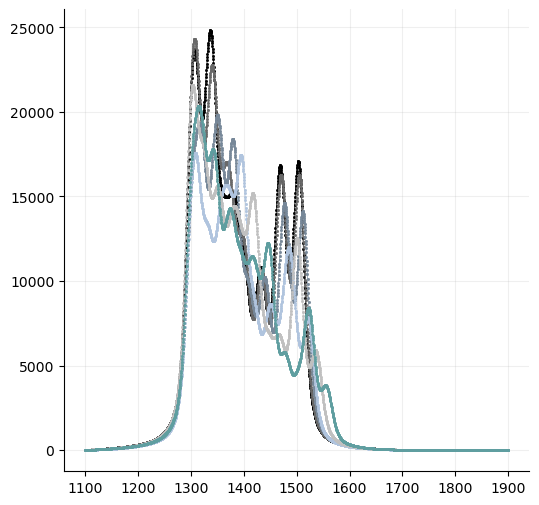

<Figure size 600x600 with 0 Axes>

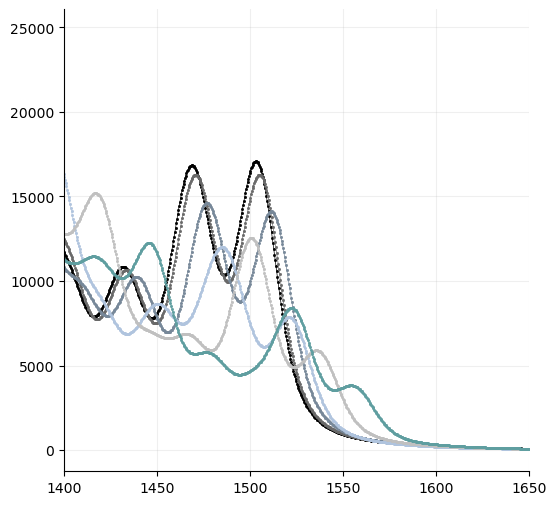

index_1450: 896
index_1650: 1407
1151
0.03857261169249804
0.14662167886321198 at 1764.7399999999789
0.20534343323774573
0.7596364173040033 at 1778.3899999999744
0.30149606025847575
1.1907677484756194 at 1796.3299999999685
2.2042460332208864
2.8652633745185554 at 1542.42
2.9016032683367716
4.183087344462955 at 1559.24


0.43113133117161606
2.9016032683367716


C:\Users\jmcc0\AppData\Local\Temp\ipykernel_3324\69283356.py:67: RuntimeWarning: divide by zero encountered in divide
  FOM[i-1] = results[i]/results[0]-1
C:\Users\jmcc0\AppData\Local\Temp\ipykernel_3324\69283356.py:67: RuntimeWarning: invalid value encountered in divide
  FOM[i-1] = results[i]/results[0]-1


<Figure size 600x600 with 0 Axes>

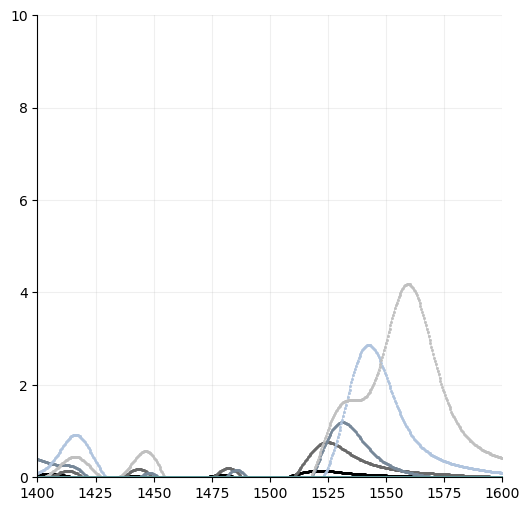

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 80.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5262359999999999Ga0.127191Al0.346573As', 30.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.0726

In [21]:
    PLOT_LIMIT=[1400,1600]
    i=0
    data = []
    legend = []

    x_array, y_array_in = read_in("absorption_{}.txt".format(i))

    num_discrete = 1024 # Base 2 for FFT
    func_x = np.zeros(num_discrete)
    Gauss_y = np.zeros(num_discrete)
    Lorentz_y = np.zeros(num_discrete)
    x_0 = (x_array[len(x_array)-1]+x_array[0])/2
    print(x_0)
    gamma = 15

    sigma = 7

    for i in range(num_discrete):
        func_x[i] = x_array[i]
        Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
        Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

    Gauss_y = Gauss_y/abs(sum(Gauss_y))
    Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
    WL_xaxis = np.zeros(num_discrete)
    WL_axis_new = pad_func_linear(x_array) # for plotting
    Lorentz_y_new = pad_func_zeros(Lorentz_y)
    Gauss_y_new = pad_func_zeros(Gauss_y)
    voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
    func_x_new = pad_func_linear(func_x)
    #N_V = abs(max(voigt_y))
    voigt_y *= 1000000
    results=[]

    for i in range(0,num_electric_fields):
        y_array_in=[]
        x_array, y_array_in = read_in("absorption_{}.txt".format(i))
        y_array = pad_func_zeros(y_array_in)
        absorption = convolve(voigt_y, y_array)
        results.append(absorption)

    PLOT_LIMIT=[]
    plot_graphs(func_x_new, results)
    PLOT_LIMIT=[1400,1650]
    plot_graphs(func_x_new, results)

    PLOT_LIMIT=[]
    Y_LIMIT = []
    LEGEND=False
    label_x = ""
    label_y = ""
    plot_title = ""
    #plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])
    PLOT_LIMIT=[]

    FOM = np.zeros((num_electric_fields,2*num_discrete))
    FOM_1550 = np.zeros((num_electric_fields))
    max_FOM = np.zeros((num_electric_fields))
    index_1550 = np.abs(func_x_new - 1550).argmin()
    index_1450 = np.abs(func_x_new - 1450).argmin()
    index_1650 = np.abs(func_x_new - 1650).argmin()

    print("index_1450:", index_1450)
    print("index_1650:", index_1650)
    print(index_1550)
    for i in range(1,num_electric_fields):
        FOM[i-1] = results[i]/results[0]-1
        FOM_1550[i-1] = FOM[i-1][index_1550]
        print(FOM_1550[i-1])
        max_FOM[i-1] = max(FOM[i-1][j] for j in range(index_1450,index_1650))
        index = np.abs(FOM[i-1] - max_FOM[i-1]).argmin()
        max_FOM_WL = func_x_new[index]
        print(str(max_FOM[i-1])+" at "+str(max_FOM_WL))

    dn_dE = (max_FOM[2]-max_FOM[1])/(3-2) # AU/(V/um)
    MAX_FOM=max(FOM_1550)


    FOM_data = [MAX_FOM, dn_dE]

    print("\n")
    print(dn_dE)
    print(MAX_FOM)

    Y_LIMIT = [0,10]
    PLOT_LIMIT=[1400,1600]
    plot_graphs(func_x_new, FOM)
    Y_LIMIT=[]

    input_file = "input.txt"
    materials_file = "materials.txt"
    simulation_params_file = "simulation_parameters.txt"
    layers = parse_input_file(input_file)
    materials = parse_materials_file(materials_file)

    qwi_target_shift, num_electric_fields, efield = parse_simulation_parameters_file(simulation_params_file)
    print("Layers:", layers)
    print("Materials:", materials)
    print("QWI Target Shift:", qwi_target_shift)
    print("Number of Electric Fields:", num_electric_fields)
    print("Max Applied Electric Field:", max_electric_field)
    print("FOM:", FOM_data)
    input_=[materials,layers,qwi_target_shift,max_electric_field] 
    #input_features_matrix.append(input_)
    figure_of_merit = np.append(FOM_data[0],FOM_data[1]) # result is max(FOM)


Machine Learning Data Collection

Run:5
x = 0.403941
y = 0.0651691
0.8227856310647967
x = 0.0889808
y = 0.385426
1.3105231823298122
x = 0.139319
y = 0.334242
1.2182669746591699
Initial Bandgap: 1311.3644535628925
1450.0


<Figure size 600x600 with 0 Axes>

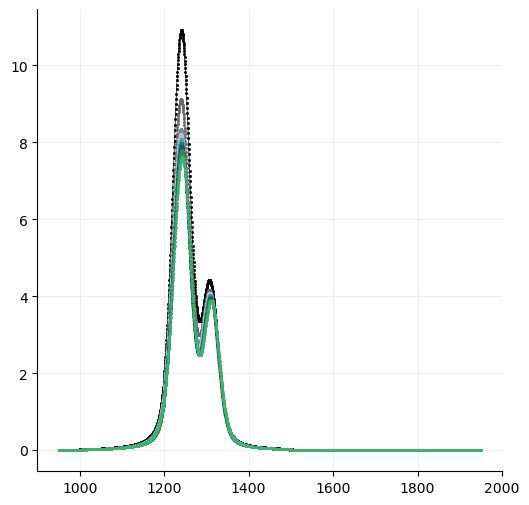

index_1450: 1105
index_1650: 1433
1228
0.0 at 1691.69
25.08950119486924 at 1691.69
496.5965160378474 at 1709.3100000000002
5750.542757477433 at 1717.1500000000003
28756.060861276947 at 1734.3000000000006
69605.6517238522 at 1748.020000000001
86251.56420680527 at 1761.2500000000011
80847.0077967329 at 1787.7100000000016
[ 0.         -0.01286672 -0.01621829 -0.00062079  0.00290914  0.02164111
  0.02527892  0.03835825]


-0.0033515710041688296
0.7109442488415352


<Figure size 600x600 with 0 Axes>

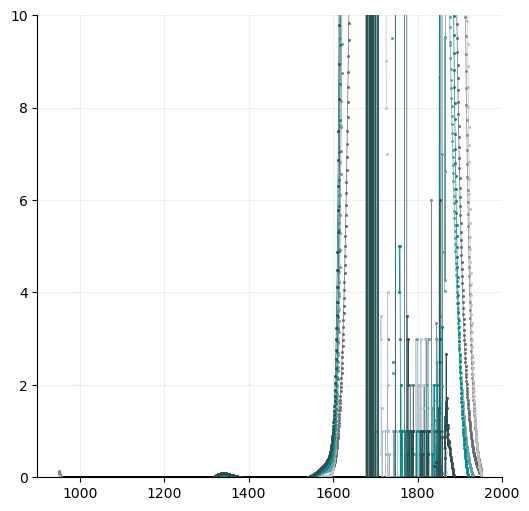

Layers: [('In0.5264390000000001Ga0.139319Al0.334242As', 95.70020955020993), ('In0.5308899Ga0.403941Al0.0651691As', 45.376279010254706), ('In0.5255932000000001Ga0.0889808Al0.385426As', 53.362556681467964), ('In0.5308899Ga0.403941Al0.0651691As', 45.376279010254706), ('In0.5264390000000001Ga0.139319Al0.334242As', 95.70020955020993)]
Materials: {'GaAs': [0.111, 1.42, 0.063, 0.082, 0.51, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.14, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.026, 0.41, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5308899Ga0.403941Al0.0651691As': [0.2936440214768164, 0.8227856310647967, 0.0474341157, 0.05735335539999999, 0.475158358, 3.538800410330036], 'In0.5255932000000001Ga0.0889808Al0.385426As': [0.1259110775967776, 1.3105231823298122, 0.075508334, 0.0826300088, 0.5653599600000001, 3.5342593717775466], 'In0.5264390000000001Ga0.139319Al0.334242As': [0.15763798741471152, 1.2182669746591699, 0.0710214939999999

KeyboardInterrupt: 

In [75]:
layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer6 = Layer(GaP, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1610), 150)
layer3 = Layer(InGaAlAs_material(1550), 180)
layer7 = Layer(InGaAlAs_material(1200), 30)

# with open('input.txt', 'w') as f:
#     f.write(str(int(len(layers))) + "\n")
#     for layer in layers:
#         f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

# with open('materials.txt', 'w') as f:
#     for material in materials:
#         f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
#     for material in alloys:
#         f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")


for iter in range(1000):
    alloys=[]
    clear_output()
    print("Run:" + str(iter))
    layer3 = Layer(InGaAlAs_material(random.uniform(1400, 1600)), random.uniform(30,100))
    layer2 = Layer(InGaAlAs_material(random.uniform(800,1350)), random.uniform(30,100))
    InP_layer = Layer(InGaAlAs_material(random.uniform(800,1350)), random.uniform(95,105))
    layers = [InP_layer, layer3, layer2, layer3, InP_layer]
    with open('input.txt', 'w') as f:
        f.write(str(int(len(layers))) + "\n")
        for layer in layers:
            f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")
    with open('materials.txt', 'w') as f:
        for material in materials:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        for material in alloys:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

    print("Initial Bandgap: " + str(getGap(layers)))
    #layers, check = findAlloys(layers, 1550)
    check == True
    if(check == True):
        with open('input.txt', 'w') as f:
            f.write(str(int(len(layers))) + "\n")
            for layer in layers:
                f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

        with open('materials.txt', 'w') as f:
            for material in materials:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
            for material in alloys:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

        for k in range(10):
            num_electric_fields = 10 # simulation cxx - not python
            max_electric_field = 10
            wavelength_shift = k*50/10 #max_shift/num_runs + j*max_shift/num_runs

            QWI_params = ["True", wavelength_shift]
            # FOM_DATA_QWI_x.append(wavelength_shift)
            write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
            subprocess.run(['simulation_multithread.exe'])

            i=0
            data = []
            legend = []

            x_array, y_array_in = read_in("absorption_{}.txt".format(i))

            num_discrete = 1024 # Base 2 for FFT
            func_x = np.zeros(num_discrete)
            Gauss_y = np.zeros(num_discrete)
            Lorentz_y = np.zeros(num_discrete)
            x_0 = (x_array[len(x_array)-1]+x_array[0])/2
            print(x_0)
            gamma = 15

            sigma = gamma

            for i in range(num_discrete):
                func_x[i] = x_array[i]
                Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
                Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

            Gauss_y = Gauss_y/abs(sum(Gauss_y))
            Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
            WL_xaxis = np.zeros(num_discrete)
            WL_axis_new = pad_func_linear(x_array) # for plotting
            Lorentz_y_new = pad_func_zeros(Lorentz_y)
            Gauss_y_new = pad_func_zeros(Gauss_y)
            voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
            func_x_new = pad_func_linear(func_x)
            #N_V = abs(max(voigt_y))
            #voigt_y /= N_V
            results=[]

            for i in range(0,10):
                y_array_in=[]
                x_array, y_array_in = read_in("absorption_{}.txt".format(i))
                y_array = pad_func_zeros(y_array_in)
                absorption = convolve(voigt_y, y_array)
                results.append(absorption)

            PLOT_LIMIT=[]
            plot_graphs(func_x_new, results)

            PLOT_LIMIT=[]
            Y_LIMIT = []
            LEGEND=False
            label_x = ""
            label_y = ""
            plot_title = ""
            #plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])
            PLOT_LIMIT=[]

            FOM = np.zeros((8,2*num_discrete))
            FOM_1550 = np.zeros(8)
            max_FOM = np.zeros(8)
            index_1550 = np.abs(func_x_new - 1550).argmin()
            index_1450 = np.abs(func_x_new - 1490).argmin()
            index_1650 = np.abs(func_x_new - 1650).argmin()

            print("index_1450:", index_1450)
            print("index_1650:", index_1650)
            print(index_1550)
            for i in range(1,9):
                FOM[i-1] = results[i]/results[1]-1
                FOM_1550[i-1] = FOM[i-1][index_1550]
                #print(FOM_1550)
                max_FOM[i-1] = max(FOM[i-1][j] for j in range(index_1450,index_1650))
                index = np.abs(FOM[i-1] - max_FOM[i-1]).argmin()
                max_FOM_WL = func_x_new[index]
                print(str(max_FOM[i-1])+" at "+str(max_FOM_WL))
            print(FOM_1550)
            dn_dE = (FOM_1550[2]-FOM_1550[1])/(3-2) # AU/(V/um)
            dN_DE = (max_FOM[2]-max_FOM[1])/(3-2)

            print("\n")
            print(dn_dE)
            print(MAX_FOM)
            
            FOM_data = [MAX_FOM, dn_dE, max(max_FOM), dN_DE]

            Y_LIMIT = [0,10]
            plot_graphs(func_x_new, FOM)
            Y_LIMIT=[]

            input_file = "input.txt"
            materials_file = "materials.txt"
            simulation_params_file = "simulation_parameters.txt"
            layers = parse_input_file(input_file)
            materials_out = parse_materials_file(materials_file)

            qwi_target_shift, num_electric_fields, efield = parse_simulation_parameters_file(simulation_params_file)
            print("Layers:", layers)
            print("Materials:", materials_out)
            print("QWI Target Shift:", qwi_target_shift)
            print("Number of Electric Fields:", num_electric_fields)
            print("Max Applied Electric Field:", max_electric_field)
            print("FOM:", FOM_data)
#             input_=[materials,layers,qwi_target_shift,max_applied_efield] 
#             #input_features_matrix.append(input_)
#             figure_of_merit = np.append(MAX_FOM, dn_dE) # result is max(FOM)
            data_dict = {
                "Layers": layers,
                "Materials": materials_out,
                "QWI Target Shift": qwi_target_shift,
                "Number of Electric Fields": num_electric_fields,
                "Max Applied Electric Field": max_electric_field,
                "FOM": FOM_data
            }
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            write_data_to_file("Z:\FYP\data_{}.txt".format(timestamp), data_dict)

In [74]:
def write_data_to_file(filename, data_dict):
    with open(filename, 'w') as f:
        for key, value in data_dict.items():
            f.write(f"{key}:\n")
            if isinstance(value, list):
                for item in value:
                    f.write(f"{item}\n")
            elif isinstance(value, dict):
                for subkey, subvalue in value.items():
                    f.write(f"{subkey}: {subvalue}\n")
            else:
                f.write(f"{value}\n")

def read_data_from_file(filename):
    data_dict = {}
    with open(filename, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
            key = lines[i].strip(":\n")
            i += 1
            if key in ["Layers", "Materials"]:
                data_dict[key] = {}
                while i < len(lines) and lines[i] != "\n":
                    line = lines[i].strip("\n")
                    if line and ":" in line:
                        subkey, subvalue = line.split(": ", 1)  # Limit split to 1 occurrence
                        data_dict[key][subkey] = subvalue
                    i += 1
            else:
                if i < len(lines):
                    value = lines[i].strip("\n")
                    data_dict[key] = value
                    i += 1
    return data_dict




# Sample data
# layers = [('InP', 100.0), ('In0.5314824Ga0.439174Al0.0293436As', 180.0), ('InP', 100.0)]
# materials = {'GaAs': [0.111, 1.42, 0.063, 0.082, 0.51, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.14, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.026, 0.41, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5316538Ga0.449376Al0.0189702As': [0.31173295583249855, 0.7701862290418768, 0.0433842554, 0.0537070628, 0.46214627599999997, 3.5419361757802292], 'In0.5312122Ga0.423147Al0.0456408As': [0.30147987984921865, 0.8000003493770904, 0.045722261599999994, 0.0558120992, 0.469658204, 3.540290998724055], 'In0.5283129999999999Ga0.250731Al0.220956As': [0.2212366328838581, 1.0333334315677287, 0.061090651999999995, 0.06964904, 0.51903638, 3.519742616325398], 'In0.5314642999999999Ga0.438139Al0.0303967As': [0.3074036836552433, 0.7827749821016479, 0.0443859409, 0.0546089418, 0.46536464599999994, 3.541285128552987], 'In0.5314824Ga0.439174Al0.0293436As': [0.3078068971747445, 0.7816025089422958, 0.0442935972, 0.0545257864, 0.465067968, 3.541348490164707]}
# qwi_target_shift = 0.0
# num_electric_fields = 10
# max_applied_efield = 10.0
# FOM_data = [-0.20272791518117428, 0.38468410085942684]

# Create data dictionary
data_dict = {
    "Layers": layers,
    "Materials": materials,
    "QWI Target Shift": qwi_target_shift,
    "Number of Electric Fields": num_electric_fields,
    "Max Applied Electric Field": max_electric_field,
    "FOM": FOM_data
}

# Write data to file
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
write_data_to_file("Z:\FYP\data_{timestamp}.txt", data_dict)

In [145]:
def read_data(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()

    # Extracting layers
    layers = []
    for line in data:
        if line.strip() == 'Layers:':
            break
    for line in data[data.index('Layers:\n') + 1:]:
        if line.strip() == 'Materials:':
            break
        layer_info = line.strip().replace("(", "").replace(")", "").replace("'", "").split(', ')
        layer = (layer_info[0], float(layer_info[1]))
        layers.append(layer)

    # Extracting materials
    materials = {}
    for line in data[data.index('Materials:\n') + 1:]:
        if line.strip() == 'QWI Target Shift:':
            break
        material_info = line.strip().split(': ')
        material_name = material_info[0]
        properties = [float(prop) for prop in material_info[1][1:-1].split(', ')]
        materials[material_name] = properties

    # Extracting QWI target shift
    qwi_target_shift = float(data[data.index('QWI Target Shift:\n') + 1])

    # Extracting number of electric fields
    number_of_electric_fields = int(data[data.index('Number of Electric Fields:\n') + 1])

    # Extracting max applied electric field
    max_applied_electric_field = int(data[data.index('Max Applied Electric Field:\n') + 1])

    # Extracting FOM elements
    fom_elements = [float(data[data.index('FOM:\n') + i]) for i in range(1, 3)]

    return materials, layers, qwi_target_shift, max_applied_electric_field, fom_elements


# Example usage:
file_path = 'data.txt'  # Replace 'your_file_path_here.txt' with the actual file path
materials, layers, qwi_target_shift, max_applied_electric_field, fom_elements = read_data(file_path)
input_ = [materials, layers, qwi_target_shift, max_applied_electric_field]
print(input_)
print(fom_elements)

[{'GaAs': [0.111, 1.42, 0.063, 0.082, 0.51, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.14, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.026, 0.41, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5316538Ga0.449376Al0.0189702As': [0.31173295583249855, 0.7701862290418768, 0.0433842554, 0.0537070628, 0.46214627599999997, 3.5419361757802292], 'In0.5312122Ga0.423147Al0.0456408As': [0.30147987984921865, 0.8000003493770904, 0.045722261599999994, 0.0558120992, 0.469658204, 3.540290998724055], 'In0.5283129999999999Ga0.250731Al0.220956As': [0.2212366328838581, 1.0333334315677287, 0.061090651999999995, 0.06964904, 0.51903638, 3.519742616325398], 'In0.5314642999999999Ga0.438139Al0.0303967As': [0.3074036836552433, 0.7827749821016479, 0.0443859409, 0.0546089418, 0.46536464599999994, 3.541285128552987], 'In0.5314824Ga0.439174Al0.0293436As': [0.3078068971747445, 0.7816025089422958, 0.0442935972, 0.0545257864, 0.465067968, 3.541348490164707]}, [

In [153]:
input_file = "input.txt"
materials_file = "materials.txt"
simulation_params_file = "simulation_parameters.txt"
layers = parse_input_file(input_file)
materials_out = parse_materials_file(materials_file)

qwi_target_shift, num_electric_fields, efield = parse_simulation_parameters_file(simulation_params_file)
print("Layers:", layers)
print("Materials:", materials_out)
print("QWI Target Shift:", qwi_target_shift)
print("Number of Electric Fields:", num_electric_fields)
print("Max Applied Electric Field:", max_electric_field)
print("FOM:", FOM_data)
#             input_=[materials,layers,qwi_target_shift,max_applied_efield] 
#             #input_features_matrix.append(input_)
#             figure_of_merit = np.append(MAX_FOM, dn_dE) # result is max(FOM)
data_dict = {
    "Layers": layers,
    "Materials": materials_out,
    "QWI Target Shift": qwi_target_shift,
    "Number of Electric Fields": num_electric_fields,
    "Max Applied Electric Field": max_electric_field,
    "FOM": FOM_data
}
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
write_data_to_file("Z:\FYP\data_{}.txt".format(timestamp), data_dict)

Layers: [('InP', 102.96558086984754), ('In0.5313511Ga0.431415Al0.0372339As', 258.9968545591504), ('InP', 102.96558086984754)]
Materials: {'GaAs': [0.111, 1.42, 0.063, 0.082, 0.51, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.14, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.026, 0.41, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5316538Ga0.449376Al0.0189702As': [0.31173295583249855, 0.7701862290418768, 0.0433842554, 0.0537070628, 0.46214627599999997, 3.5419361757802292], 'In0.5312122Ga0.423147Al0.0456408As': [0.30147987984921865, 0.8000003493770904, 0.045722261599999994, 0.0558120992, 0.469658204, 3.540290998724055], 'In0.5283129999999999Ga0.250731Al0.220956As': [0.2212366328838581, 1.0333334315677287, 0.061090651999999995, 0.06964904, 0.51903638, 3.519742616325398], 'In0.5313511Ga0.431415Al0.0372339As': [0.3047676904684835, 0.7904399811908012, 0.0449853053, 0.0551485826, 0.467290382, 3.5408572879752316]}
QWI Target Shift: 100.

In [115]:
FOM_DATA_QWI_x = []
FOM_DATA_QWI_y = []
FOM_DATA_QWI_y_all = []
max_shift = 50
num_runs = 20
num_electric_fields = 10 # simulation cxx - not python
max_electric_field = 10

def read_in(file_path):
    x_data_ = []
    y_data_ = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split the line into x and y values
                x_val, y_val = map(float, line.strip().split())
                x_data_.append(x_val)
                y_data_.append(y_val)
    except FileNotFoundError:
        print("File not found:", file_path)

materials = [GaAs, GaP, InP, InAs, AlAs]
# Write materials and layers information to files

for w in range(1):
    wavelength_shift = random.uniform(0, max_shift/num_runs)
    QWI_params = ["True", wavelength_shift]
    FOM_DATA_QWI_x.append(wavelength_shift)
    write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
    layer1 = Layer(InP, 50)
    layer2 = Layer(new_InGaAlAs_material(0.124, 0.0), 90)
    layer3 = Layer(new_InGaAlAs_material(0.15, 0.15), random.uniform(30, 100))
    layers = [layer1, layer3, layer1]

    with open('input.txt', 'w') as f:
        f.write(str(int(len(layers))) + "\n")
        for layer in layers:
            f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

    with open('materials.txt', 'w') as f:
        for material in materials:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        for material in alloys:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

    # Run the C++ executable with material and layer files
    #subprocess.run(['simulation with absorption.exe'])

    # Now x_array and y_array contain your data

    data = []
    legend = []

    i=0
    y_array_in=[]
    x_array=[]
    x_array, y_array_in = read_in("absorption_{}.txt".format(i))
    print(len(y_array_in))
    #voigt_y = voigt_y
    y_array = pad_func_zeros(y_array_in)
    print(len(y_array))
    absorption = convolve(voigt_y, y_array)
    plot_graph(func_x_new, absorption)
    results.append(absorption)

    num_discrete = 1024 # Base 2 for FFT
    func_x = np.zeros(num_discrete)
    Gauss_y = np.zeros(num_discrete)
    Lorentz_y = np.zeros(num_discrete)
    x_0 = (x_array[len(x_array)-1]+x_array[0])/2
    print(x_0)
    gamma = 15

    #WL_range=[1000,1400]
    #PLOT_LIMIT=WL_range
    #delta_WL = (WL_range[1]-WL_range[0]) / (num_discrete-1)
    #epsilon = delta_WL*0.5
    sigma = gamma

    for i in range(num_discrete):
        func_x[i] = x_array[i]
        Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
        Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

    Gauss_y = Gauss_y/abs(sum(Gauss_y))
    Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
    WL_xaxis = np.zeros(num_discrete)
    WL_axis_new = pad_func_linear(x_array) # for plotting
    Lorentz_y_new = pad_func_zeros(Lorentz_y)
    Gauss_y_new = pad_func_zeros(Gauss_y)
    voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
    func_x_new = pad_func_linear(func_x)
    N_V = abs(max(voigt_y))
    voigt_y /= N_V
    results=[]

    for i in range(0,11):
        y_array_in=[]
        x_array, y_array_in = read_in("absorption_{}.txt".format(i))
        y_array = pad_func_zeros(y_array_in)
        absorption = convolve(voigt_y, y_array)
        results.append(absorption)

    PLOT_LIMIT=[]
    plot_graphs(func_x_new, results)

    PLOT_LIMIT=[]
    Y_LIMIT = []
    LEGEND=False
    label_x = ""
    label_y = ""
    plot_title = ""
    
    # plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])
    
    # Example usage:
    input_file = "input.txt"
    materials_file = "materials.txt"
    simulation_params_file = "simulation_parameters.txt"
    layers = parse_input_file(input_file)
    materials = parse_materials_file(materials_file)
    
    
    for j in range (1,11):
        efield = j*max_electric_field/num_electric_fields
        qwi_target_shift, num_electric_fields, efield = parse_simulation_parameters_file(simulation_params_file)
        print("Layers:", layers)
        print("Materials:", materials)
        print("QWI Target Shift:", qwi_target_shift)
        print("Number of Electric Fields:", num_electric_fields)
        print("Max Applied Electric Field:", max_applied_efield)
        print("FOM:", result)
        input_=[materials,layers,qwi_target_shift,max_applied_efield] 
        input_features_matrix.append(input_)
        figure_of_merit = np.append(FOM[j], result) # result is max(FOM)
        
    # clear_output(wait=True)
    
    

NameError: name 'new_InGaAlAs_material' is not defined

In [ ]:
PLOT_LIMIT=[]
Y_LIMIT=[]
plot_graphs_distinct(x_values, y_values)
num_electric_fields = 10

print(read_in("absorption_{}.txt".format(i)))

In [ ]:
wavelength_shift = random.uniform(0, max_shift/num_runs)
QWI_params = ["True", wavelength_shift]
FOM_DATA_QWI_x.append(wavelength_shift)
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
layer1 = Layer(InP, 50)
layer2 = Layer(new_InGaAlAs_material(0.124, 0.0), 90)
layer3 = Layer(new_InGaAlAs_material(0.15, 0.15), random.uniform(30, 100))
layers = [layer1, layer3, layer1]

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

# Run the C++ executable with material and layer files
#subprocess.run(['simulation with absorption.exe'])

    # Convert lists to numpy arrays
#     x_array_ = np.array(x_data_)
#     y_array_ = np.array(y_data_)

    #plot_graph(x_array_, y_array_)

    #return x_array_, y_array_

# Now x_array and y_array contain your data

data = []
legend = []

i=0
#y_array_in=[]
x_array, y_array_in = read_in("absorption_{}.txt".format(i))
# print(len(y_array_in))
# #voigt_y = voigt_y
# y_array = pad_func_zeros(y_array_in)
# print(len(y_array))
# absorption = convolve(voigt_y, y_array)
# plot_graph(func_x_new, absorption)
# results.append(absorption)

num_discrete = 1024 # Base 2 for FFT
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = (x_array[len(x_array)-1]+x_array[0])/2
print(x_0)
gamma = 15

#WL_range=[1000,1400]
#PLOT_LIMIT=WL_range
#delta_WL = (WL_range[1]-WL_range[0]) / (num_discrete-1)
#epsilon = delta_WL*0.5
sigma = gamma

for i in range(num_discrete):
    func_x[i] = x_array[i]
    Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
    Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

Gauss_y = Gauss_y/abs(sum(Gauss_y))
Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
WL_xaxis = np.zeros(num_discrete)
WL_axis_new = pad_func_linear(x_array) # for plotting
Lorentz_y_new = pad_func_zeros(Lorentz_y)
Gauss_y_new = pad_func_zeros(Gauss_y)
voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
func_x_new = pad_func_linear(func_x)
N_V = abs(max(voigt_y))
voigt_y /= N_V
results=[]

for i in range(0,11):
    y_array_in=[]
    x_array, y_array_in = read_in("absorption_{}.txt".format(i))
    y_array = pad_func_zeros(y_array_in)
    absorption = convolve(voigt_y, y_array)
    results.append(absorption)

PLOT_LIMIT=[]
plot_graphs(func_x_new, results)

PLOT_LIMIT=[]
Y_LIMIT = []
LEGEND=False
label_x = ""
label_y = ""
plot_title = ""
#plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])

In [ ]:
PLOT_LIMIT=[1100,1400]
Y_LIMIT=[0,2500]
plot_graphs_distinct(x_values, y_values)
num_electric_fields = 10

In [ ]:
def read_in(file_path):
    x_data_ = []
    y_data_ = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split the line into x and y values
                x_val, y_val = map(float, line.strip().split())
                x_data_.append(x_val)
                y_data_.append(y_val)
    except FileNotFoundError:
        print("File not found:", file_path)

    # Convert lists to numpy arrays
    x_array_ = np.array(x_data_)
    y_array_ = np.array(y_data_)
    
    #plot_graph(x_array_, y_array_)
    
    return x_array_, y_array_

# Now x_array and y_array contain your data

data = []
legend = []

#y_array_in=[]
x_array, y_array_in = read_in("absorption_{}.txt".format(i))
# print(len(y_array_in))
# #voigt_y = voigt_y
# y_array = pad_func_zeros(y_array_in)
# print(len(y_array))
# absorption = convolve(voigt_y, y_array)
# plot_graph(func_x_new, absorption)
# results.append(absorption)
    
num_discrete = 1024 # Base 2 for FFT
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = (x_array[len(x_array)-1]+x_array[0])/2
print(x_0)
gamma = 15

#WL_range=[1000,1400]
#PLOT_LIMIT=WL_range
#delta_WL = (WL_range[1]-WL_range[0]) / (num_discrete-1)
#epsilon = delta_WL*0.5
sigma = gamma

for i in range(num_discrete):
    func_x[i] = x_array[i]
    Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
    Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

Gauss_y = Gauss_y/abs(sum(Gauss_y))
Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
WL_xaxis = np.zeros(num_discrete)
WL_axis_new = pad_func_linear(x_array) # for plotting
Lorentz_y_new = pad_func_zeros(Lorentz_y)
Gauss_y_new = pad_func_zeros(Gauss_y)
voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
func_x_new = pad_func_linear(func_x)
N_V = abs(max(voigt_y))
voigt_y /= N_V
results=[]

for i in range(0,11):
    y_array_in=[]
    x_array, y_array_in = read_in("absorption_{}.txt".format(i))
    y_array = pad_func_zeros(y_array_in)
    absorption = convolve(voigt_y, y_array)
    results.append(absorption)
    
PLOT_LIMIT=[]
plot_graphs(func_x_new, results)

PLOT_LIMIT=[]
Y_LIMIT = []
LEGEND=False
label_x = ""
label_y = ""
plot_title = ""
#plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])

In [ ]:
def parse_input_file(input_file):
    layers = []
    with open(input_file, 'r') as f:
        num_layers = int(f.readline().strip())
        for _ in range(num_layers):
            layer_info = f.readline().strip().split()
            material = layer_info[0]
            thickness = float(layer_info[1])
            layers.append((material, thickness))
    return layers

def parse_materials_file(materials_file):
    materials = {}
    with open(materials_file, 'r') as f:
        for line in f:
            material_info = line.strip().split()
            material = material_info[0]
            properties = [float(prop) for prop in material_info[1:]]
            materials[material] = properties
    return materials

def parse_simulation_parameters_file(simulation_params_file):
    with open(simulation_params_file, 'r') as f:
        qwi_target_shift = float(f.readline().strip())
        num_electric_fields = int(f.readline().strip())
        max_applied_efield = float(f.readline().strip())
    return qwi_target_shift, num_electric_fields, max_applied_efield

In [280]:
input_features_matrix=[]
figure_of_merit=[]

def parse_input_file(input_file):
    layers = []
    with open(input_file, 'r') as f:
        num_layers = int(f.readline().strip())
        for _ in range(num_layers):
            layer_info = f.readline().strip().split()
            material = layer_info[0]
            thickness = float(layer_info[1])
            layers.append((material, thickness))
    return layers

def parse_materials_file(materials_file):
    materials = {}
    with open(materials_file, 'r') as f:
        for line in f:
            material_info = line.strip().split()
            material = material_info[0]
            properties = [float(prop) for prop in material_info[1:]]
            materials[material] = properties
    return materials

def parse_simulation_parameters_file(simulation_params_file):
    with open(simulation_params_file, 'r') as f:
        qwi_target_shift = float(f.readline().split(" ")[1])
        num_electric_fields = int(f.readline().strip())
        max_applied_efield = float(f.readline().strip())
    return qwi_target_shift, num_electric_fields, max_applied_efield

# Example usage:
input_file = "input.txt"
materials_file = "materials.txt"
simulation_params_file = "simulation_parameters.txt"
layers = parse_input_file(input_file)
materials = parse_materials_file(materials_file)
qwi_target_shift, num_electric_fields, max_applied_efield = parse_simulation_parameters_file(simulation_params_file)


print("Layers:", layers)
print("Materials:", materials)
print("QWI Target Shift:", qwi_target_shift)
print("Number of Electric Fields:", num_electric_fields)
print("Max Applied Electric Field:", max_applied_efield)
print("FOM:", result)

input_=[materials,layers,qwi_target_shift,max_applied_efield] 

input_features_matrix.append(input_)
input_features_matrix
figure_of_merit = np.append(figure_of_merit, result) # result is max(FOM)

Layers: [('In0.528183Ga0.243024Al0.228793As', 89.0289077941682), ('In0.5313256Ga0.429848Al0.0388264As', 292.5981108718892), ('In0.528183Ga0.243024Al0.228793As', 89.0289077941682)]
Materials: {'GaAs': [0.111, 1.42, 0.063, 0.082, 0.51, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.14, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.026, 0.41, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5310663999999999Ga0.414452Al0.0544816As': [0.2979668979117418, 0.8102154756855429, 0.046497243199999996, 0.0565098464, 0.47214820799999996, 3.5396467989971483], 'In0.527835Ga0.222298Al0.249867As': [0.20587694824506203, 1.0779966611076999, 0.063625029, 0.07193086600000001, 0.52717926, 3.516192408697903], 'In0.528163Ga0.241809Al0.230028As': [0.21648136774867566, 1.0471608963399952, 0.061885916, 0.07036505600000001, 0.52159154, 3.518555674248365], 'In0.5313177Ga0.429388Al0.0392943As': [0.30396689613928185, 0.7927685485917946, 0.0451658961, 0.0553111642,

NameError: name 'result' is not defined

In [ ]:
print(len(input_features_matrix))
input_features_matrix